# Проект для «Викишоп»

## Содержание
1. Подготовка  
    1.1. Библиотеки и функции  
    1.2. Данные  
    1.3. Добавление признаков  
2. Обучение  
    2.1. Логистическая регрессия  
    2.1.1. Несбалансированная выборка  
    2.1.2. Балансировка классов  
    2.2. Случайный лес  
    2.3. Gradient Boosting Decision Tree  
3. Тестирование  
4. Выводы  

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

**Задача:** обучить модель классифицировать комментарии на позитивные и негативные на основании набора данных с разметкой о токсичности правок.

Метрика качества *F1* должна быть не меньше 0.75. 

## Подготовка

### Библиотеки и функции

In [1]:
import pandas as pd
import numpy as np
import math
import re

from scipy.sparse import vstack, hstack
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
def clean(text):
    text =  re.sub(r'\n', ' ', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub('[\d-]', '', text)
    text = re.sub("i'm", 'i am', text)
    text = re.sub("can't", 'cannot', text)
    text = re.sub("don't", 'do not', text)
    text = re.sub("\'re", ' are', text)
    text = re.sub("\'ll", ' will', text)
    text = re.sub("\'ve", ' have', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    return text

In [3]:
def count_words(text):
    words = text.split(' ')
    return len(words)
def count_phrase_len(text):
    return len(text)

In [4]:
def add_phrase_len(series, size):
    return series.to_numpy().reshape((1, size)).transpose()

In [5]:
def train_valid_test_split(features, target):

    features_train_valid, features_test, target_train_valid, target_test = train_test_split(
    features, target, shuffle=False, test_size=0.2, random_state=123)

    features_train, features_valid, target_train, target_valid = train_test_split(
    features_train_valid, target_train_valid, shuffle=False, test_size=0.25, random_state=123)
    
    return features_train, features_valid, features_test, target_train, target_valid, target_test

In [6]:
def find_best_regression(features_train, target_train, 
                         features_valid, target_valid, class_weight):
    best_model = None
    best_result = 0
    best_C = 0
    C_dict = {}
    
    for C in tqdm([0.01, 0.05, 0.1, 0.5, 1]):
        result_list = []
        model = LogisticRegression(random_state=123, penalty='l2', C=C,
                                   class_weight=class_weight)
        model.fit(features_train, target_train)
        predicted = model.predict(features_valid)
        f1 = f1_score(target_valid, predicted)
        result_list.append(f1)
        if f1 > best_result:
            best_model = model
            best_result = f1
            best_C = C
                
        C_dict[C] = result_list
    return best_model, best_result, best_C, C_dict

In [7]:
def find_best_forest(features_train, target_train, 
                     features_valid, target_valid, 
                     max_est, max_depth):
    best_model = None
    best_result = 0
    best_est = 0
    best_depth = 0
    est_dict = {}
    
    for est in tqdm(range(1, max_est, 1)):
        result_list = []
        for depth in range (10, max_depth, 10):
            model = RandomForestClassifier(random_state=12345,
                                           n_estimators=est,
                                           max_depth=depth)
            model.fit(features_train, target_train)
            predicted = model.predict(features_valid)
            f1 = f1_score(target_valid, predicted)
            result_list.append(f1)
            if f1 > best_result:
                best_model = model
                best_result = f1
                best_est = est
                best_depth = depth
                
        est_dict[est] = result_list
    return best_model, best_result, best_est, best_depth, est_dict

### Данные

In [8]:
data = pd.read_csv('toxic_comments.csv')
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


0    0.898321
1    0.101679
Name: toxic, dtype: float64


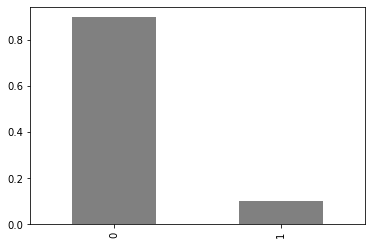

In [10]:
class_frequency = data['toxic'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar', color='grey'); 

**Выводы:** в данных 159571 наблюдений, пропусков нет, целевая метка сильно несбалансирована. Это интуитивно понятно, ведь токсичных комментариев обычно меньше, чем нормальных.

### Добавление признаков

Приведем строки к нижнему регистру, удалим небуквенные символы. Затем добавим в таблицу столбцы с количеством слов и количеством символов в каждом комментарии.

In [11]:
data['text'] = data['text'].str.lower()
data['text'] = data['text'].apply(clean)

In [12]:
data['phrase_len'] = data['text'].apply(count_phrase_len)
data['words'] = data['text'].apply(count_words)

In [13]:
toxic_words = data.query('toxic == 1 and words < 125')['words']
non_toxic_words = data.query('toxic == 0 and words < 125')['words']
toxic_phrase_len = data.query('toxic == 1 and phrase_len < 1000')['phrase_len']
non_toxic_phrase_len = data.query('toxic == 0 and phrase_len < 1000')['phrase_len']

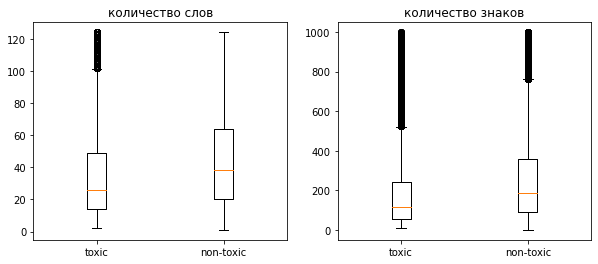

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].boxplot([toxic_words, non_toxic_words])
axs[0].set_title('количество слов')

axs[1].boxplot([toxic_phrase_len, non_toxic_phrase_len])
axs[1].set_title('количество знаков');

for ax in axs:
    ax.set_xticklabels(['toxic', 'non-toxic'])

In [15]:
data.corr()

,toxic,phrase_len,words
toxic,1.000000,-0.051202,-0.042257
phrase_len,-0.051202,1.000000,0.972298
words,-0.042257,0.972298,1.000000


In [16]:
data = data.drop('words', axis=1)

**Выводы:** по графикам кажется, что токсичные комментарии в среднем короче, чем нетоксичные. Однако оба эти признака добавить в таблицу не можем, потому что они сильно коррелируют. 

Посмотрим, повлияет ли добавление  признака длины фразы на метрику качества.

In [17]:
data.head(4)

,text,toxic,phrase_len
0,explanation why the edits made under my userna...,0,257
1,d aww he matches this background colour i am ...,0,103
2,hey man i am really not trying to edit war i...,0,234
3,more i cannot make any real suggestions on i...,0,619


## Обучение

Обучим логистическую регрессию и случайный лес, подбирая лучшие параметры циклом. 

Без стоп-слов метрика получается лучше.

**Разбиваем данные на выборки**

In [18]:
features = data.drop('toxic', axis=1)
target = data['toxic']

In [19]:
(features_train, features_valid, features_test, 
 target_train, target_valid, target_test) = train_valid_test_split(features, target)

for i in (features_train, features_valid, features_test, 
          target_train, target_valid, target_test):
    print(i.shape)

(95742, 2)
(31914, 2)
(31915, 2)
(95742,)
(31914,)
(31915,)


**Проверяем, в каком соотношении метки классов в каждой подвыборке**

In [20]:
print('Обучающая:')
print(target_train.value_counts(normalize=True))
print('Валидационная')
print(target_valid.value_counts(normalize=True))
print('Тестовая')
print(target_test.value_counts(normalize=True))

Обучающая:
0    0.897976
1    0.102024
Name: toxic, dtype: float64
Валидационная
0    0.898728
1    0.101272
Name: toxic, dtype: float64
Тестовая
0    0.89895
1    0.10105
Name: toxic, dtype: float64


**Векторизируем**

In [21]:
features_train_text = features_train['text'].astype('U').values
features_valid_text = features_valid['text'].astype('U').values

In [22]:
features_train_phrase_len = add_phrase_len(features_train['phrase_len'], 
                                           features_train_text.shape[0])
features_valid_phrase_len = add_phrase_len(features_valid['phrase_len'],
                                           features_valid_text.shape[0])

In [23]:
count_tf_idf = TfidfVectorizer()
tf_idf_features_train = count_tf_idf.fit_transform(features_train_text)
tf_idf_features_valid = count_tf_idf.transform(features_valid_text)

In [24]:
features_train = hstack([tf_idf_features_train, features_train_phrase_len])
features_valid = hstack([tf_idf_features_valid, features_valid_phrase_len])

In [25]:
models_dict = {}
params_dict = {}

### Логистическая регрессия

#### Несбалансированная выборка

In [26]:
# %%time
# LR_raw_params = {'C':np.logspace(-3,3,7), 
#          'penalty':['l1','l2']}
# gs_LR_raw = GridSearchCV(LogisticRegression(class_weight=None),
#                      param_grid=LR_raw_params,
#                      scoring='f1')
# gs_LR_raw.fit(features_train, target_train)

# print('params_raw:', gs_LR_raw.best_params_, 
#       'f1_score_raw:', gs_LR_raw.best_score_)
# # params_raw: {'C': 10.0, 'penalty': 'l1'} f1_score_raw: 0.7680947305745737
# # CPU times: user 4min 43s, sys: 2min 49s, total: 7min 32s
# # Wall time: 7min 34s

In [27]:
params_dict['LR_raw'] = {'C': 10.0, 'penalty': 'l2'}

In [28]:
LR_model_raw = LogisticRegression(class_weight=None,
                                  C=10.0,
                                  penalty='l2')
LR_model_raw.fit(features_train, target_train)
LR_predictions_raw = LR_model_raw.predict(features_valid)
f1_LR_raw = f1_score(target_valid, LR_predictions_raw)
models_dict['LR_raw'] = f1_LR_raw
print('F1 логистической регрессии: {:.2f}'.format(f1_LR_raw))

F1 логистической регрессии: 0.71


**Вывод:** Предсказания логистической регрессии дали результат F1 = 0.79. Попробуем его улучшить, добавив балансировку классов.

#### Балансировка классов

In [29]:
# (regr_model_balanced, regr_result_balanced, 
#  regr_C_balanced, regr_results_dict_balanced) = find_best_regression(features_train_scaled, target_train,
#                                            features_valid_scaled, target_valid, 'balanced')
# models_dict['LR_balanced'] = regr_result_balanced

# print('F1 логистической регрессии с балансировкой классов: {:.2f}'.format(regr_result_balanced))

In [30]:
# %%time
# LR_balanced_params = {'C' : np.logspace(-3,3,7),
#                       'penalty' : ['l1','l2']}
# gs_LR_balanced = GridSearchCV(LogisticRegression(class_weight='balanced'),
#                               param_grid=LR_balanced_params,
#                               scoring='f1')
# gs_LR_balanced.fit(features_train, target_train)
# print('params:', gs_LR_balanced.best_params_, 
#       'f1_score:', gs_LR_balanced.best_score_)
# # params: {'C': 10.0, 'penalty': 'l2'} f1_score: 0.7683286533117502
# # CPU times: user 6min 32s, sys: 4min 13s, total: 10min 46s
# # Wall time: 10min 47s

In [31]:
params_dict['LR_balanced'] = {'C': 10.0, 'penalty': 'l2'}

In [32]:
LR_model_balanced = LogisticRegression(class_weight='balanced',
                                       C=10.0,
                                       penalty='l2')
LR_model_balanced.fit(features_train, target_train)
LR_predictions_balanced = LR_model_balanced.predict(features_valid)
f1_LR_balanced = f1_score(target_valid, LR_predictions_balanced)
models_dict['LR_balanced'] = f1_LR_balanced
print('F1 логистической регрессии с балансировкой классов: {:.2f}'.format(f1_LR_balanced))

F1 логистической регрессии с балансировкой классов: 0.68


**Вывод:** банасировка классов встроенным параметром `class_weight='balanced'` не привела к улучшению показателя, F1 = 0.77.

### Случайный лес

Подберем параметры для случайного леса в цикле, запишем их в переменные для дальнейшего использования, потому что подбор параметров занимает время.

In [33]:
# %%time
# max_est, max_depth = 6, 200

# (forest_model,
#  forest_result, 
#  forest_est, 
#  forest_depth,
#  forest_results_dict) = find_best_forest(tf_idf_train, target_train,
#                                          tf_idf_valid, target_valid, 
#                                          max_est, max_depth)

# regr_dict['RF'] = forest_result

# print('F1 случайного леса: {:.2f}'.format(forest_result))
# # Wall time: 6min 44s

In [34]:
# print('Лучшие параметры для случайного леса: \nКоличество деревьев: {} \nГлубина дерева {}'.format(forest_est, forest_depth))
print('Лучшие параметры для случайного леса: \nКоличество деревьев: 4 \nГлубина дерева 160')

Лучшие параметры для случайного леса: 
Количество деревьев: 4 
Глубина дерева 160


In [35]:
# forest = RandomForestClassifier(random_state=12345, 
#                                 n_estimators=4, 
#                                 max_depth=160).fit(features_train_scaled, target_train)
# forest_predicted = forest.predict(features_valid_scaled)
# forest_f1 = f1_score(target_valid, forest_predicted)
# models_dict['RF'] = forest_f1
# print('F1 случайного леса: {:.2f}'.format(forest_f1))

In [36]:
# %%time
# RF_params = {'max_depth':range(150,200,10), 
#              'n_estimators':range(1, 6), 
#              'criterion':['gini', 'entropy']}

# gs_RF = GridSearchCV(RandomForestClassifier(),
#                      param_grid=RF_params,
#                      scoring='f1')

# gs_RF.fit(features_train, target_train)
# print('params:', gs_RF.best_params_, 'f1_score:', gs_RF.best_score_)
# # params: {'criterion': 'gini', 'max_depth': 190, 'n_estimators': 4} f1_score: 0.5006735830066068
# # CPU times: user 22min 18s, sys: 0 ns, total: 22min 18s
# # Wall time: 22min 33s

In [37]:
params_dict['RF'] = {'max_depth': 190, 'n_estimators': 4, 'criterion': 'gini'}

In [38]:
RF_model = RandomForestClassifier(max_depth=190,
                                  n_estimators=4,
                                  criterion='gini')
RF_model.fit(features_train, target_train)
RF_predictions = RF_model.predict(features_valid)
f1_RF = f1_score(target_valid, RF_predictions)
models_dict['RF'] = f1_RF
print('F1 случайного леса: {:.2f}'.format(f1_RF))

F1 случайного леса: 0.52


**Вывод:** случайный лес показывает более низкий результат, чем линейная регрессия. Однако метрика улучшилась после добавления признака длины фразы.

### Gradient Boosting Decision Tree

In [39]:
model_lgb = LGBMClassifier()

param_set = {
    "learning_rate": [0.1, 0.5, 1.0],
    "max_depth":[10, 15, 20],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "n_estimators":[10, 15, 20, 25, 30]
    }

# grid_cv = GridSearchCV(model_lgb, 
#                        param_grid=param_set, 
#                        scoring='f1', 
#                        n_jobs=-1, 
#                        cv=3, 
#                        verbose=1)

# grid_cv.fit(tf_idf_train, target_train,
#         eval_set=[(tf_idf_valid, target_valid)],
#         eval_metric='l1',
#         early_stopping_rounds=5)
# # Wall time: 4h 24min 8s

In [40]:
# print(grid_cv.best_params_)
# best_cv_params = grid_cv.best_params_
best_cv_params = {'criterion': 'friedman_mse', 
                  'learning_rate': 0.5, 
                  'max_depth': 20, 
                  'max_features': 'log2', 
                  'n_estimators': 30}

In [41]:
model_lgb = LGBMClassifier(learning_rate=0.5, 
                           num_iterations=20, 
                           max_depth=30,
                           n_estimators=50,
                          criterion ='friedman_mse', 
                           max_features= 'log2')
model_lgb.fit(features_train, target_train)
lgb_predicted = model_lgb.predict(features_valid)
gbm_f1 = f1_score(target_valid, lgb_predicted)
models_dict['GBM'] = gbm_f1
params_dict['GBM'] = best_cv_params
print('F1 GBM на валидационной выборке: {:.2f}'.format(gbm_f1))

[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
F1 GBM на валидационной выборке: 0.75


**Выводы:** В результате долгого подбора параметров метрика бустинга улучшилась, но все равно не превзошла линейную регрессию.

## Тестирование
Выберем модель с лучшим результатом, дообучим её на объединенных тренировочных и валидационных данных, затем проверим на тестовой выборке.

In [42]:
results_df = pd.DataFrame.from_dict(models_dict, orient='index',
                                    columns=['F1']).iloc[0:5].round(decimals=2)
print(results_df)

F1_max = results_df['F1'].max()
best_model_name = results_df.query('F1 == @F1_max').index[0]
print('\nЛучшая модель:', best_model_name)
print('Параметры лучшей модели:', params_dict[best_model_name])

               F1
LR_raw       0.71
LR_balanced  0.68
RF           0.52
GBM          0.75

Лучшая модель: GBM
Параметры лучшей модели: {'criterion': 'friedman_mse', 'learning_rate': 0.5, 'max_depth': 20, 'max_features': 'log2', 'n_estimators': 30}


In [43]:
features_concatenated = vstack([features_train, features_valid])
target_concatenated = pd.concat([target_train, target_valid])

In [44]:
features_test_text = features_test['text'].astype('U').values
features_test_phrase_len = add_phrase_len(features_test['phrase_len'],
                                          features_test_text.shape[0])
tf_idf_features_test = count_tf_idf.transform(features_test_text)
features_test = hstack([tf_idf_features_test, features_test_phrase_len])

In [45]:
test_model = LGBMClassifier(learning_rate=0.5, 
                           num_iterations=20, 
                           max_depth=30,
                           n_estimators=50)
test_model.fit(features_concatenated, target_concatenated)

test_predicted = test_model.predict(features_test)

test_f1 = f1_score(target_test, test_predicted)
print('F1 GBM на тестовой выборке после дообучения модели: {:.2f}'.format(test_f1))

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
F1 логистической регрессии на тестовой выборке после дообучения модели: 0.75


## Выводы

Для нового сервиса интернет-магазина "Викишоп" мы сделали модель, отличающую позитивные комментарии от негативных.

Лучший результат F1 был получен с помощью GBM. На валидационной  и на тестовой выборках F1 = 0.79. Чистка данных и добавление длины фразы в качестве признака не дало улучшения показателей. Наверное, на этих объемах данных лишние символы в строках не мешают векторизации.